## II. 分析

### 数据的探索

加载9张图片

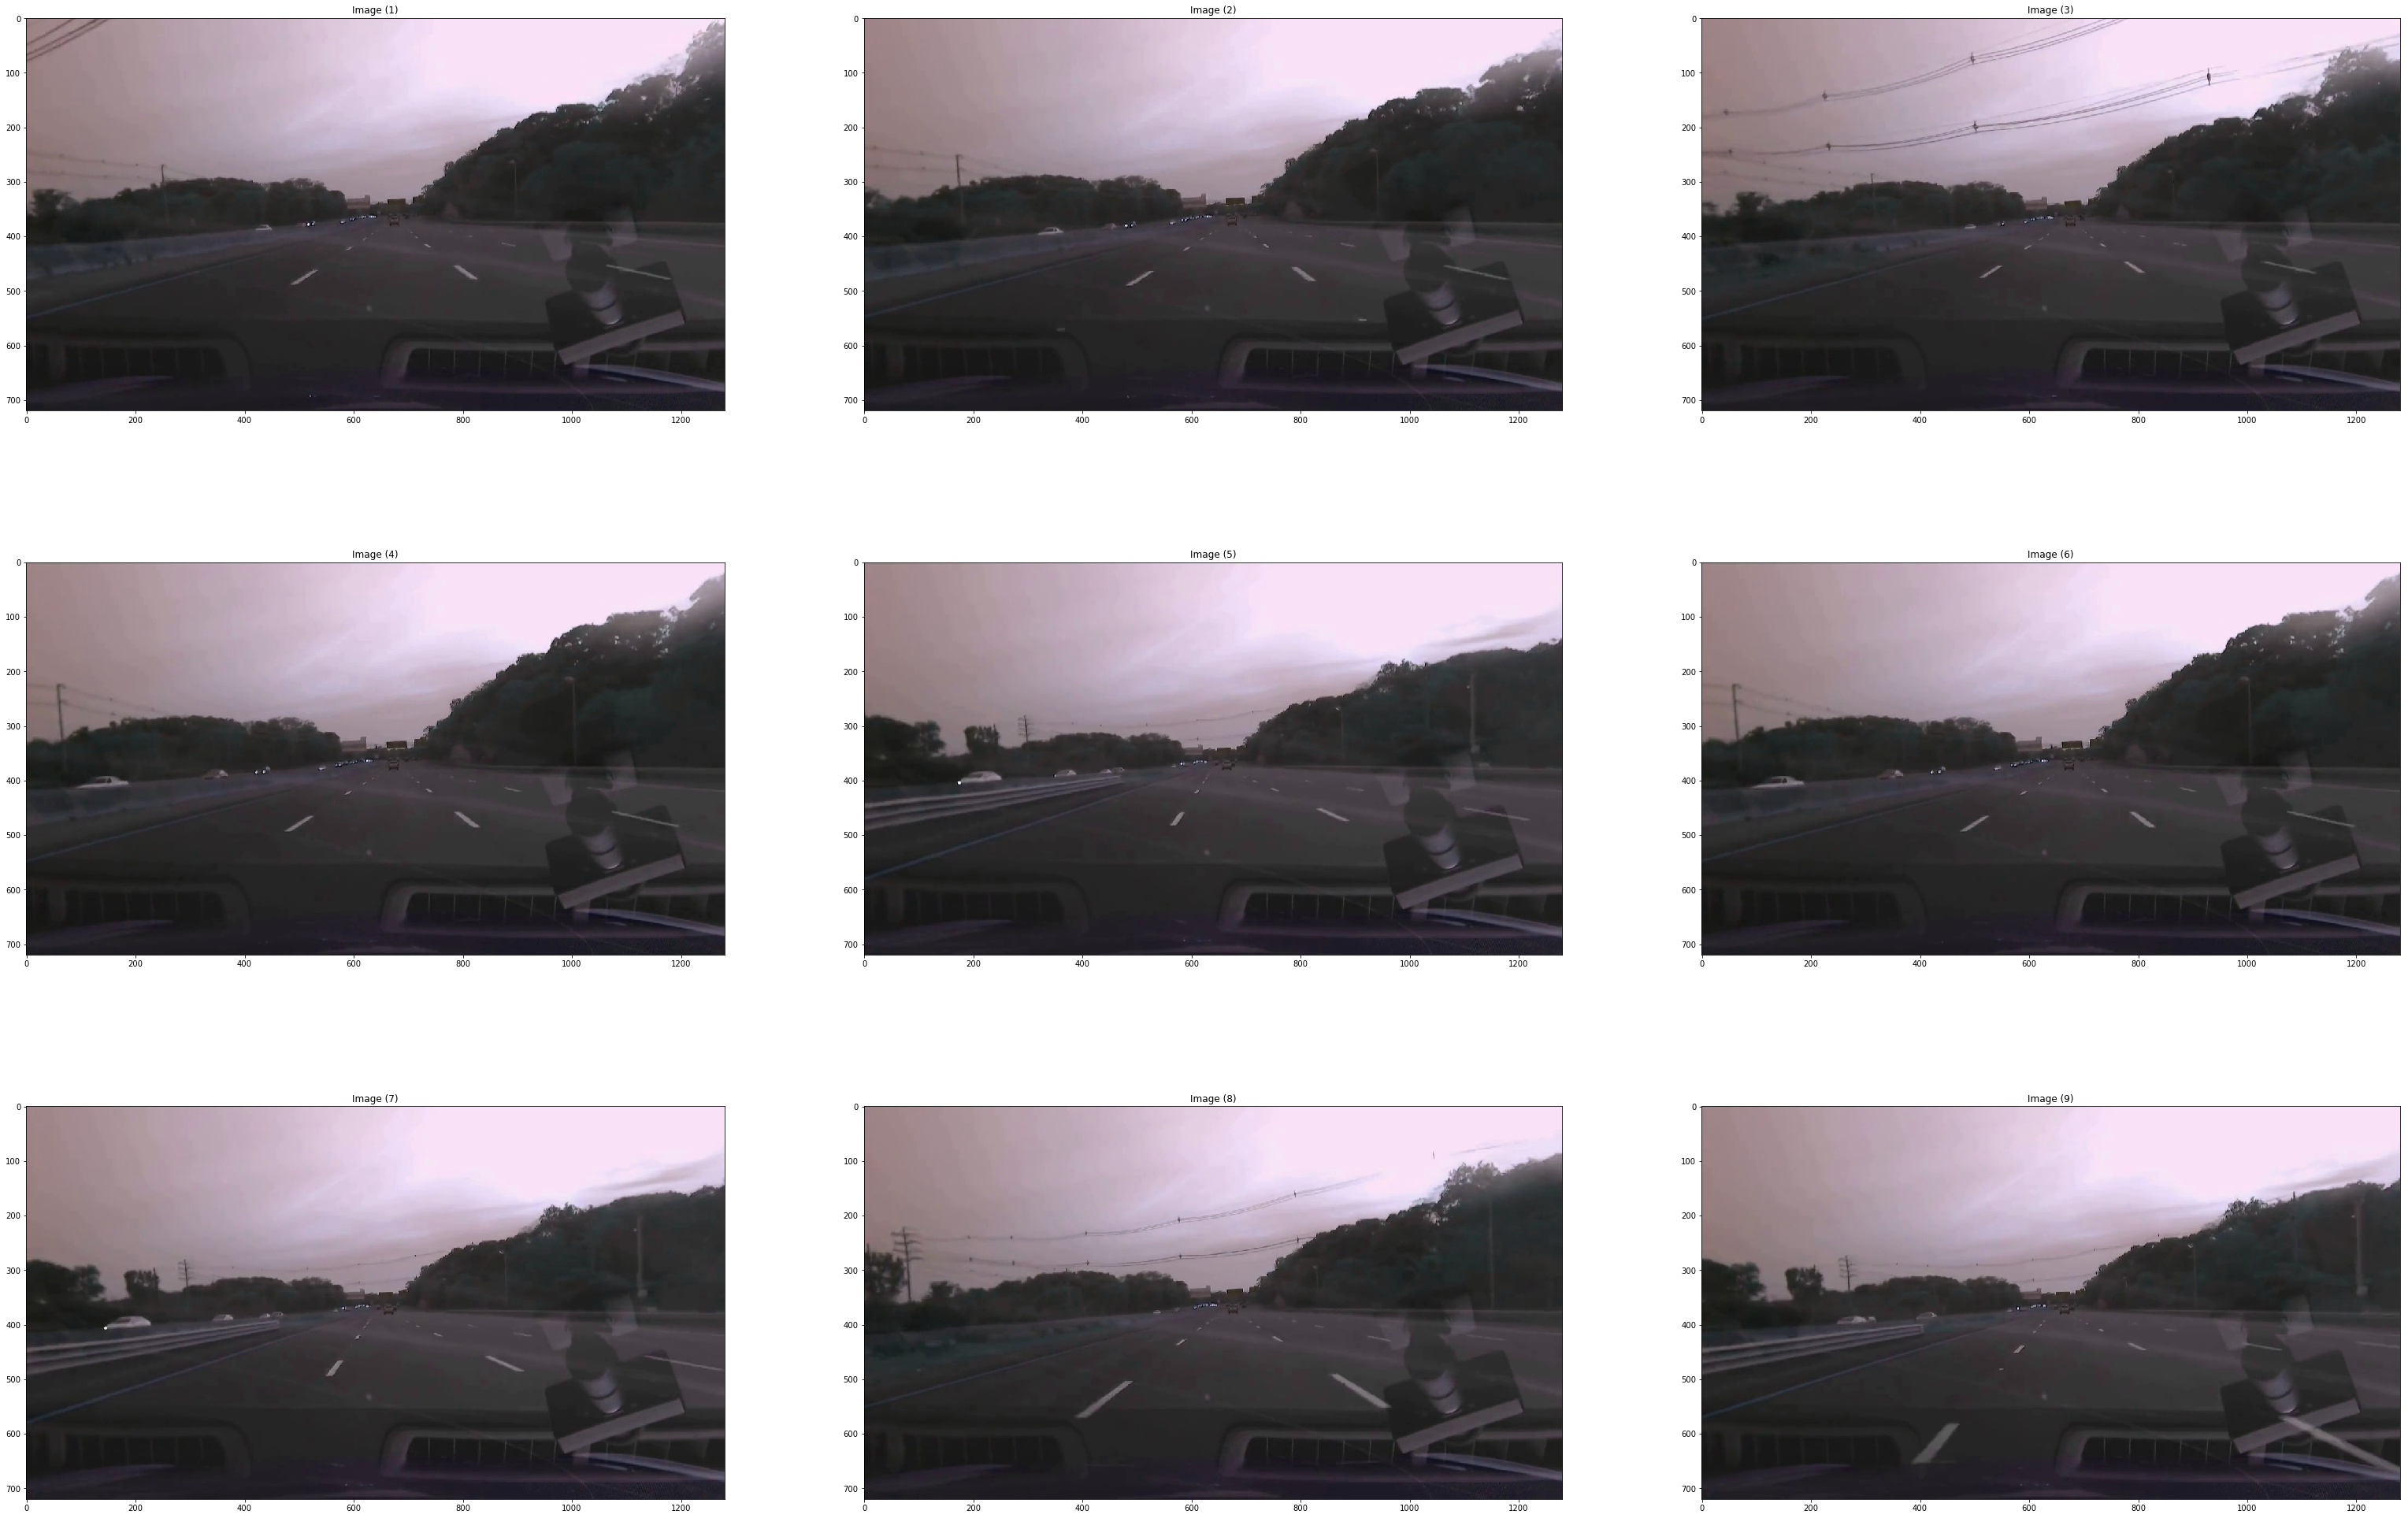

(720, 1280, 3)


In [1]:
## Load front-roadway data
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
%matplotlib inline

def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

import random
def get_random_images():
    imgs = []
    cap = cv2.VideoCapture("./epochs/epoch01_front.mkv")
    for i in range(100):
        ret, img = cap.read()
        if(ret):
            imgs.append(img)
    cap.release()
    random_imgs = []
    for i in range(9):
        index = random.randint(0, 99)
        random_imgs.append(imgs[index])
    return random_imgs

show_images(get_random_images(),cols=3)
print(get_random_images()[0].shape)

显示CVS

In [2]:
import pandas as pd
wheel_sig = pd.read_csv('./epochs/epoch01_steering.csv')
wheel_sig.head()

,ts_micro,frame,wheel
0,1464650070285914,0,-1.0
1,1464650070319247,1,-1.0
2,1464650070352581,2,-1.0
3,1464650070385914,3,-1.0
4,1464650070419247,4,-1.0


### 探索性可视化

labels可视化

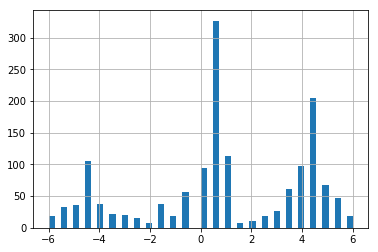

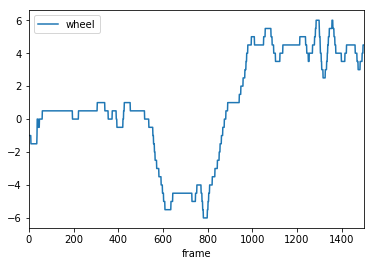

In [3]:
wheel_sig.wheel.hist(bins=50)
wheel_sig.plot(x='frame',y='wheel')

## III. 方法

### 数据预处理

In [4]:
import datasets
def myGenerator():
    #loading data
    (X_train, y_train) = datasets.load_train()
    #some preprocessing
    batch_size = 512
    while 1:
        for i in range(84):
            yield X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]

Using TensorFlow backend.


In [5]:
import datasets
(X_val, y_val) = datasets.load_data(9)
(X_test, y_test) = datasets.load_data(10)

In [6]:
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(2700, 143, 400, 3)
(2700, 1)
(2700, 143, 400, 3)
(2700, 1)


In [7]:
# Save train data into a pickle file.
import pickle

pickle.dump(X_val, open('imgs_val.p', 'wb'))
pickle.dump(y_val, open('wheels_val.p', 'wb'))

# Save test data into a pickle file.
pickle.dump(X_test, open('imgs_test.p', 'wb'))
pickle.dump(y_test, open('wheels_test.p', 'wb'))

# Checkpoint

In [8]:
# Load data back from the pickle file.
import pickle

X_val = pickle.load(open('imgs_val.p', 'rb'))
y_val = pickle.load(open('wheels_val.p', 'rb'))

X_test = pickle.load(open('imgs_test.p', 'rb'))
y_test = pickle.load(open('wheels_test.p', 'rb'))

In [9]:
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(2700, 143, 400, 3)
(2700, 1)
(2700, 143, 400, 3)
(2700, 1)


### 执行过程

英伟达模型

In [10]:
from keras.layers import *
from keras.models import Model
from keras import optimizers
from keras.models import model_from_json
import keras
import os
import params


inputs = Input(shape=(params.FLAGS.img_h, params.FLAGS.img_w, params.FLAGS.img_c))
x=Lambda(lambda x:x/255.0)(inputs)
x=Conv2D(24, (5, 5), activation="relu", strides=(2, 2), padding="valid")(x)
x=Conv2D(36, (5, 5), activation="relu", strides=(2, 2), padding="valid")(x)
x=Conv2D(48, (5, 5), activation="relu", strides=(2, 2), padding="valid")(x)
x=Conv2D(64, (3, 3), activation="relu", strides=(1, 1), padding="valid")(x)
x=Conv2D(64, (3, 3), activation="relu", strides=(1, 1), padding="valid")(x)
x=Flatten()(x)
x=Dense(1164, activation='relu')(x)
x=Dense(100, activation='relu')(x)
x=Dense(50, activation='relu')(x)
x=Dense(10, activation='relu')(x)
outputs=Dense(1)(x)
model = Model(inputs=inputs,outputs=outputs)
model.compile(optimizer=optimizers.Adadelta(),loss='mse',metrics=['mse'])
model.fit_generator(
        myGenerator(),
        steps_per_epoch=84,
        epochs=10,
        validation_data=(X_val, y_val))
test_loss= model.evaluate(X_test, y_test)
print('Test loss is:{}'.format(test_loss))

Epoch 1/10
84/84 [==============================] - 260s - loss: 23.9434 - mean_squared_error: 23.9434 - val_loss: 8.4983 - val_mean_squared_error: 8.4983
Epoch 2/10
84/84 [==============================] - 114s - loss: 13.4931 - mean_squared_error: 13.4931 - val_loss: 9.2869 - val_mean_squared_error: 9.2869
Epoch 3/10
84/84 [==============================] - 114s - loss: 5.7348 - mean_squared_error: 5.7348 - val_loss: 18.7677 - val_mean_squared_error: 18.7677
Epoch 4/10
84/84 [==============================] - 114s - loss: 2.6394 - mean_squared_error: 2.6394 - val_loss: 13.0682 - val_mean_squared_error: 13.0682
Epoch 5/10
84/84 [==============================] - 114s - loss: 1.7327 - mean_squared_error: 1.7327 - val_loss: 3.7360 - val_mean_squared_error: 3.7360
Epoch 6/10
84/84 [==============================] - 114s - loss: 1.3818 - mean_squared_error: 1.3818 - val_loss: 8.4199 - val_mean_squared_error: 8.4199
Epoch 7/10
84/84 [==============================] - 114s - loss: 1.1628 - 

In [11]:
weights_file = './models/original_model.h5'
model_file = './models/original_model.json'
model.save_weights(weights_file)
with open(model_file, 'w') as f:
    f.write(model.to_json())

In [12]:
from keras.layers import *
from keras.models import Model
from keras import optimizers
from keras.models import model_from_json
import keras
import os

import params


inputs = Input(shape=(params.FLAGS.img_h, params.FLAGS.img_w, params.FLAGS.img_c))
x=Lambda(lambda x:x/255.0)(inputs)
x=Conv2D(24, (3, 3), activation="relu", strides=(2, 2), padding="valid")(x)
X=MaxPooling2D(pool_size=(2, 2))(x)
x=Conv2D(36, (3, 3), activation="relu", strides=(2, 2), padding="valid")(x)
X=MaxPooling2D(pool_size=(2, 2))(x)
x=Conv2D(48, (3, 3), activation="relu", strides=(2, 2), padding="valid")(x)
X=MaxPooling2D(pool_size=(2, 2))(x)
x=Conv2D(64, (3, 3), activation="relu", strides=(1, 1), padding="valid")(x)
x=Conv2D(64, (3, 3), activation="relu", strides=(1, 1), padding="valid")(x)
x=Flatten()(x)
x=Dense(1164, activation='relu')(x)
X=Dropout(0.5)(x)
x=Dense(100, activation='relu')(x)
X=Dropout(0.5)(x)
x=Dense(50, activation='relu')(x)
X=Dropout(0.5)(x)
x=Dense(10, activation='relu')(x)
X=Dropout(0.5)(x)
outputs=Dense(1)(x)
model = Model(inputs=inputs,outputs=outputs)
model.compile(optimizer=optimizers.Adadelta(),loss='mse',metrics=['mse'])
model.fit_generator(
        myGenerator(),
        steps_per_epoch=84,
        epochs=10,
        validation_data=(X_val, y_val))
test_loss= model.evaluate(X_test, y_test)
print('Test loss is:{}'.format(test_loss))

Epoch 1/10
84/84 [==============================] - 218s - loss: 23.3206 - mean_squared_error: 23.3206 - val_loss: 2.2361 - val_mean_squared_error: 2.2361
Epoch 2/10
84/84 [==============================] - 91s - loss: 18.8985 - mean_squared_error: 18.8985 - val_loss: 3.1848 - val_mean_squared_error: 3.1848
Epoch 3/10
84/84 [==============================] - 91s - loss: 10.6619 - mean_squared_error: 10.6619 - val_loss: 1.7428 - val_mean_squared_error: 1.7428
Epoch 4/10
84/84 [==============================] - 91s - loss: 4.3756 - mean_squared_error: 4.3756 - val_loss: 1.4944 - val_mean_squared_error: 1.4944
Epoch 5/10
84/84 [==============================] - 91s - loss: 2.2897 - mean_squared_error: 2.2897 - val_loss: 5.3180 - val_mean_squared_error: 5.3180
Epoch 6/10
84/84 [==============================] - 91s - loss: 1.4650 - mean_squared_error: 1.4650 - val_loss: 2.0756 - val_mean_squared_error: 2.0756
Epoch 7/10
84/84 [==============================] - 91s - loss: 1.1934 - mean_squ

In [13]:
weights_file = './models/maxpool_model.h5'
model_file = './models/maxpool_model.json'
model.save_weights(weights_file)
with open(model_file, 'w') as f:
    f.write(model.to_json())

In [14]:
from keras.layers import *
from keras.models import Model
from keras import optimizers
from keras.models import model_from_json
import keras
import os
import params


inputs = Input(shape=(params.FLAGS.img_h, params.FLAGS.img_w, params.FLAGS.img_c))
x=Lambda(lambda x:x/255.0)(inputs)
x=Conv2D(24, (5, 5), activation="elu", strides=(2, 2), padding="valid")(x)
x=Conv2D(36, (5, 5), activation="elu", strides=(2, 2), padding="valid")(x)
x=Conv2D(48, (5, 5), activation="elu", strides=(2, 2), padding="valid")(x)
x=Conv2D(64, (3, 3), activation="elu", strides=(1, 1), padding="valid")(x)
x=Conv2D(64, (3, 3), activation="elu", strides=(1, 1), padding="valid")(x)
x=Flatten()(x)
x=Dense(1164, activation='elu')(x)
x=Dense(100, activation='elu')(x)
x=Dense(50, activation='elu')(x)
x=Dense(10, activation='elu')(x)
outputs=Dense(1)(x)
model = Model(inputs=inputs,outputs=outputs)
model.compile(optimizer=optimizers.Adadelta(),loss='mse',metrics=['mse'])
model.fit_generator(
        myGenerator(),
        steps_per_epoch=84,
        epochs=10,
        validation_data=(X_val, y_val))
test_loss= model.evaluate(X_test, y_test)
print('Test loss is:{}'.format(test_loss))

Epoch 1/10
84/84 [==============================] - 240s - loss: 28.1222 - mean_squared_error: 28.1222 - val_loss: 3.0137 - val_mean_squared_error: 3.0137
Epoch 2/10
84/84 [==============================] - 117s - loss: 23.1744 - mean_squared_error: 23.1744 - val_loss: 2.7398 - val_mean_squared_error: 2.7398
Epoch 3/10
84/84 [==============================] - 117s - loss: 24.0862 - mean_squared_error: 24.0862 - val_loss: 6.0214 - val_mean_squared_error: 6.0214
Epoch 4/10
84/84 [==============================] - 117s - loss: 15.7584 - mean_squared_error: 15.7584 - val_loss: 3.0518 - val_mean_squared_error: 3.0518
Epoch 5/10
84/84 [==============================] - 117s - loss: 6.8124 - mean_squared_error: 6.8124 - val_loss: 6.1564 - val_mean_squared_error: 6.1564
Epoch 6/10
84/84 [==============================] - 117s - loss: 1.9799 - mean_squared_error: 1.9799 - val_loss: 4.8499 - val_mean_squared_error: 4.8499
Epoch 7/10
84/84 [==============================] - 117s - loss: 1.7245 - 

In [16]:
weights_file = './models/elu_model.h5'
model_file = './models/elu_model.json'
model.save_weights(weights_file)
with open(model_file, 'w') as f:
    f.write(model.to_json())

In [17]:
from keras.layers import *
from keras.models import Model
from keras import optimizers
from keras.models import model_from_json
import keras
import os
import params


inputs = Input(shape=(params.FLAGS.img_h, params.FLAGS.img_w, params.FLAGS.img_c))
x=Lambda(lambda x:x/255.0)(inputs)
x=Conv2D(24, (3, 3), activation="elu", strides=(2, 2), padding="valid")(x)
X=MaxPooling2D(pool_size=(2, 2))(x)
x=Conv2D(36, (3, 3), activation="elu", strides=(2, 2), padding="valid")(x)
X=MaxPooling2D(pool_size=(2, 2))(x)
x=Conv2D(48, (3, 3), activation="elu", strides=(2, 2), padding="valid")(x)
X=MaxPooling2D(pool_size=(2, 2))(x)
x=Conv2D(64, (3, 3), activation="elu", strides=(1, 1), padding="valid")(x)
x=Conv2D(64, (3, 3), activation="elu", strides=(1, 1), padding="valid")(x)
x=Flatten()(x)
x=Dense(1164, activation='elu')(x)
X=Dropout(0.5)(x)
x=Dense(100, activation='elu')(x)
X=Dropout(0.5)(x)
x=Dense(50, activation='elu')(x)
X=Dropout(0.5)(x)
x=Dense(10, activation='elu')(x)
X=Dropout(0.5)(x)
outputs=Dense(1)(x)
model = Model(inputs=inputs,outputs=outputs)
model.compile(optimizer=optimizers.Adadelta(),loss='mse',metrics=['mse'])
model.fit_generator(
        myGenerator(),
        steps_per_epoch=84,
        epochs=10,
        validation_data=(X_val, y_val))
test_loss= model.evaluate(X_test, y_test)
print('Test loss is:{}'.format(test_loss))

Epoch 1/10
84/84 [==============================] - 216s - loss: 27.5818 - mean_squared_error: 27.5818 - val_loss: 5.0842 - val_mean_squared_error: 5.0842
Epoch 2/10
84/84 [==============================] - 93s - loss: 14.5460 - mean_squared_error: 14.5460 - val_loss: 3.3578 - val_mean_squared_error: 3.3578
Epoch 3/10
84/84 [==============================] - 93s - loss: 7.4518 - mean_squared_error: 7.4518 - val_loss: 7.2448 - val_mean_squared_error: 7.2448
Epoch 4/10
84/84 [==============================] - 93s - loss: 2.7469 - mean_squared_error: 2.7469 - val_loss: 7.4878 - val_mean_squared_error: 7.4878
Epoch 5/10
84/84 [==============================] - 93s - loss: 3.7478 - mean_squared_error: 3.7478 - val_loss: 5.1951 - val_mean_squared_error: 5.1951
Epoch 6/10
84/84 [==============================] - 93s - loss: 1.0746 - mean_squared_error: 1.0746 - val_loss: 3.5869 - val_mean_squared_error: 3.5869
Epoch 7/10
84/84 [==============================] - 93s - loss: 1.6420 - mean_squar

In [18]:
weights_file = './models/maxpool_elu_model.h5'
model_file = './models/maxpool_elu_model.json'
model.save_weights(weights_file)
with open(model_file, 'w') as f:
    f.write(model.to_json())